##### Imports

In [1]:
import sys, os
from asvFormula.digraph import *
from asvFormula.classesSizes.algorithmTime import measureGraphTime
from asvFormula.bayesianNetworks.bayesianNetwork import *
from asvFormula.bayesianNetworks import *
from asvFormula.topoSorts import allForestTopoSorts
from pgmpy.readwrite import BIFReader
import pandas as pd
import seaborn as sns
import timeit
import itertools

# Experimentation

### Auxiliary Functions

In [6]:
printEnabled = True
def disablePrint():
    global printEnabled
    if printEnabled:
        sys._jupyter_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        printEnabled = False

def enablePrint():
    global printEnabled
    printEnabled = True
    sys.stdout.close()
    sys.stdout = sys._jupyter_stdout

def convertDictToCsv(dict, filename, orient='index', sortByColumn = None):

    df = pd.DataFrame.from_dict(dict, orient=orient)

    if sortByColumn is not None:
        df = df.sort_values(by=sortByColumn)
    # Save the DataFrame to a CSV file
    df.to_csv(filename)

def dataframeFromCsv(filename : str):
    df = pd.read_csv(filename, index_col=0)
    df.name = filename.split('/')[-1][:-4]
    return df

def convertCsvToDict(filename):
    df = dataframeFromCsv(filename)
    return df.to_dict()

In [7]:
resultsFolder = 'results/graphData/'

naiveBayesWithPathFile = resultsFolder + 'naiveBayes.csv'
multiplePathsFile = resultsFolder + 'multiplePaths.csv'
balancedTreesFile = resultsFolder + 'balancedTrees.csv'
childNetworkFile = resultsFolder + 'childNetwork.csv'

childNetworkPath = networkSamplesPath + "/child.bif"

## Generating the results

### Time Naive Bayes

In [ ]:
def timeMultipleNaiveBayesWithPath(numNodes, pathLength, startFrom = 1):
    graphsResults = {}
    for i in range(startFrom,numNodes+1):
        for j in range(startFrom,pathLength+1):
            graphToEvaluate = naiveBayesWithPath(i, j)
            nodesToEvaluate = list(range(i+j-3, i+j))
            print(f'{i} Children, {j} PathLength' + str(nodesToEvaluate))
            graphsResults[f'{i} Children, {j} PathLength'] = measureGraphTime(graphToEvaluate, nodesToEvaluate)
            convertDictToCsv(graphsResults, naiveBayesWithPathFile)
    return graphsResults
    

numNodes = 25
pathLenght = 25
resNaiveBayes = timeMultipleNaiveBayesWithPath(numNodes, pathLenght,21)

### Time multiple Paths

In [ ]:
def timeMultiplePathsGraphs(numPaths, pathLength, startFrom = 1):
    graphsResults = {}
    for i in range(startFrom,numPaths+1):
        for j in range(startFrom,pathLength+1):
            graphToEvaluate = multiplePaths(i, j)
            #drawGraph(graphToEvaluate)
            nodesToEvaluate = list(range(0, j))
            print(f'{i} Paths, {j} Length' + str(nodesToEvaluate))
            graphsResults[f'{i} Paths, {j} Length'] = measureGraphTime(graphToEvaluate, nodesToEvaluate)
            convertDictToCsv(graphsResults, multiplePathsFile)

    return graphsResults
    

numberOfPaths = 8
pathLenght = 8
resMultiplePaths = timeMultiplePathsGraphs(numberOfPaths, pathLenght,4)

### Time balanced trees

In [ ]:
def timeMultipleBalancedTrees(numLevels, branchingFactor = 2, startLevels = 1, starBranching = 2):
    graphsResults = {}
    for i in range(startLevels,numLevels+1):
        for j in range(starBranching,branchingFactor+1):
            graphToEvaluate = balancedTree(i, j)
            #drawGraph(graphToEvaluate)
            leafNode = [node for node in graphToEvaluate.nodes if isLeaf(node, graphToEvaluate)][0]
            pathToLeaf = orderedNodes(graphToEvaluate, nx.ancestors(graphToEvaluate, leafNode)) + [leafNode]
            print(f'{i} Levels, {j} Branching' + str(pathToLeaf))
            graphsResults[f'{i} Levels, {j} Branching'] = measureGraphTime(graphToEvaluate, pathToLeaf)
            convertDictToCsv(graphsResults, balancedTreesFile)
            

    return graphsResults

numLevels = 6
branchingFactor = 2

resBalancedTrees = timeMultipleBalancedTrees(numLevels, branchingFactor, 2, 2)


### Time child bayesian network

In [ ]:
def timeChildBayesianNetworks():
    graphsResults = {}
    childBayesianNetwork = childBNAsTree(BIFReader(childNetworkPath).get_model())
    childGraph = bayesianNetworkToDigraph(childBayesianNetwork)
    nodesToEvaluate = list(childBayesianNetwork.nodes)
    graphsResults['Child result'] = measureGraphTime(childGraph, nodesToEvaluate)
    convertDictToCsv(graphsResults, childNetworkFile)
            
    return graphsResults

resBalancedTrees = timeChildBayesianNetworks()

### Adding node count and estimated toposort time to the results

In [16]:
naiveBayesDict = convertCsvToDict(naiveBayesWithPathFile)
#multiplePathsDict = convertCsvToDict(multiplePathsFile)
#balancedTreesDict = convertCsvToDict(balancedTreesFile)
#childDict = convertCsvToDict(childNetworkFile)

nodesColumn = 'Nodes number'
toposTimeColumn = 'Toposorts estimated time'

def addNewColumnToDict(graphDict : Dict, graphKey, newColumn, columnValue):
    if graphKey in graphDict['allTopoSortsNumber'].keys():
        nodesDict = graphDict.get(newColumn, {})
        nodesDict[graphKey] = columnValue
        graphDict[newColumn] = nodesDict

def addNodeCountToDict(graphDict : Dict, graphKey, graph):
      addNewColumnToDict(graphDict, graphKey, nodesColumn, len(graph.nodes))

def addTimeToDict(graphDict : Dict, graphKey, graph):
        toposNumber = 1000
        thousandToposTime = timeit.timeit(lambda : list(itertools.islice(nx.all_topological_sorts(graph), toposNumber)), number=1)
        addNewColumnToDict(graphDict, graphKey, toposTimeColumn, allForestTopoSorts(graph)/toposNumber*thousandToposTime)

def addNodeAndToposTimeToDict(naiveBayesDict,graphKey, naiveBayesGraph):
    addNodeCountToDict(naiveBayesDict, graphKey, naiveBayesGraph)
    addTimeToDict(naiveBayesDict, graphKey, naiveBayesGraph)

def addNodeAndTimeCount(naiveBayesDict, multiplePathsDict, balancedTreesDict):
    for i in range(20,24):
        for j in range(1,26):
                naiveBayesGraph = naiveBayesWithPath(i, j)

                addNodeAndToposTimeToDict(naiveBayesDict, f'{i} Children, {j} PathLength', naiveBayesGraph)
                if i < 7 and j < 3:
                        balancedTreeGraph = balancedTree(i, j)
                        if not (balancedTreesDict is None):
                                addNodeAndToposTimeToDict(balancedTreesDict, f'{i} Levels, {j} Branching', balancedTreeGraph)
                                convertDictToCsv(balancedTreesDict, balancedTreesFile, 'columns', nodesColumn)
                if i < 9 and j < 9:
                        multiplePathsGraph = multiplePaths(i, j)
                        if not (multiplePathsDict is None):
                                addNodeAndToposTimeToDict(multiplePathsDict, f'{i} Paths, {j} Length', multiplePathsGraph)
                                convertDictToCsv(multiplePathsDict, multiplePathsFile, 'columns', nodesColumn)
        convertDictToCsv(naiveBayesDict, naiveBayesWithPathFile, 'columns', nodesColumn)

addNodeAndTimeCount(naiveBayesDict, None, None)
#addTimeToDict(childDict, 'Child result', childBNAsTree(BIFReader(childNetworkPath).get_model()))
#convertDictToCsv(childDict, childNetworkFile, 'columns', nodesColumn)

## Plotting the results 

In [8]:
plotsResultsFolder = 'results/plots/'

naiveBayesDf = dataframeFromCsv(naiveBayesWithPathFile)
dfMultiplePaths = dataframeFromCsv(multiplePathsFile)
dfBalancedTrees = dataframeFromCsv(balancedTreesFile)
dfChildNetwork = dataframeFromCsv(childNetworkFile)

dataFramesToPlot = [naiveBayesDf, dfMultiplePaths, dfBalancedTrees, dfChildNetwork]

for column in ['allTopoSortsNumber', 'biggestEquivClasses', 'smallestEquivClasses']:
    for dataframe in dataFramesToPlot:
        dataframe[column] = pd.to_numeric(dataframe[column], errors='coerce')

In [10]:
dfMultiplePaths

,allTopoSortsNumber,recursiveLongestTime,recursiveShortestTime,recursiveAverageTime,biggestEquivClasses,smallestEquivClasses,averageEquivClasses,Nodes number,Toposorts estimated time
"4 Paths, 4 Length",6.306300e+07,0.151529,0.022125,0.077246,125,125,125.0,16,1.235839e+03
"4 Paths, 5 Length",1.173275e+10,0.074056,0.016314,0.044419,216,216,216.0,20,2.368935e+05
"5 Paths, 4 Length",3.055402e+11,0.056652,0.039513,0.045762,625,625,625.0,20,6.665849e+06
"4 Paths, 6 Length",2.308743e+12,0.070453,0.038785,0.050702,343,343,343.0,24,6.478034e+07
"6 Paths, 4 Length",3.246671e+15,0.320987,0.179202,0.255703,3125,3125,3125.0,24,5.835955e+10
"5 Paths, 5 Length",6.233607e+14,0.188215,0.098360,0.122480,1296,1296,1296.0,25,1.233712e+10
"4 Paths, 7 Length",4.725183e+14,0.099746,0.041459,0.069604,512,512,512.0,28,1.060166e+10
"7 Paths, 4 Length",6.647558e+19,1.692052,1.079460,1.424642,15625,15625,15625.0,28,1.338645e+15
"6 Paths, 5 Length",8.883265e+19,0.924464,0.568910,0.749676,7776,7776,7776.0,30,1.779940e+15
"5 Paths, 6 Length",1.370874e+18,0.374528,0.219846,0.294861,2401,2401,2401.0,30,3.106401e+13


### Equivalence classes vs topological sorts number

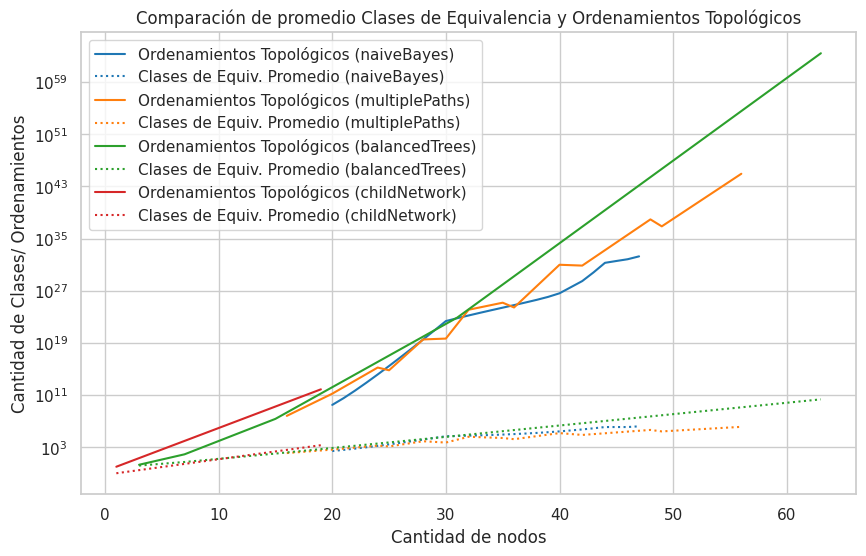

In [13]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
palette = sns.color_palette("tab10", n_colors=len(dataFramesToPlot))

# Plot each dataframe separately
for i, df in enumerate(dataFramesToPlot):
    sns.lineplot(data=df, x="Nodes number", y="allTopoSortsNumber", label=f"Ordenamientos Topológicos ({df.name})", color=palette[i], errorbar=None)
    sns.lineplot(data=df, x="Nodes number", y="averageEquivClasses", label=f"Clases de Equiv. Promedio ({df.name})", linestyle="dotted", color=palette[i], errorbar=None)

plt.yscale("log")

# Labels and title
plt.xlabel("Cantidad de nodos")
plt.ylabel("Cantidad de Clases/ Ordenamientos")
plt.title("Comparación de promedio Clases de Equivalencia y Ordenamientos Topológicos")

# Show the plot
plt.legend()
plt.savefig(plotsResultsFolder + 'equivalentClassesVsToposorts.png')

### Equivalence classes vs topological sorts time

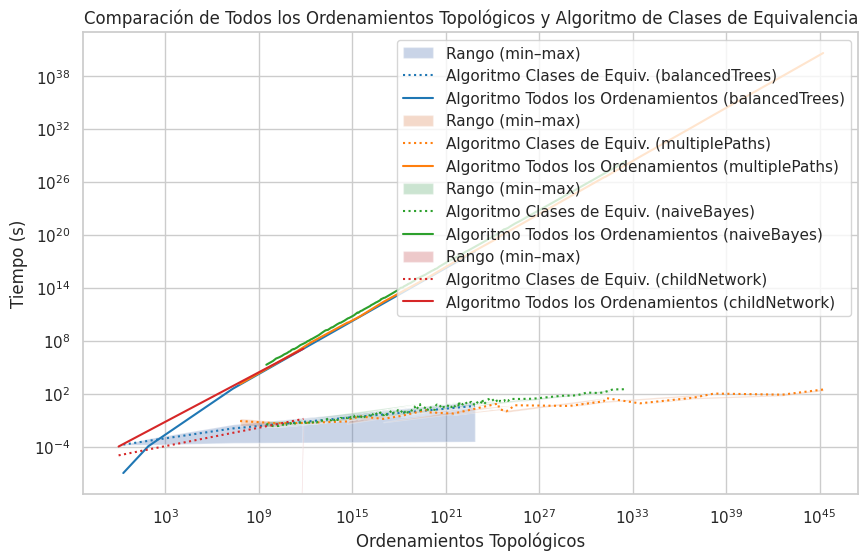

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

filteredDataFrames = [dfBalancedTrees, dfMultiplePaths, naiveBayesDf, dfChildNetwork]
for df in filteredDataFrames:
    df.dropna(inplace=True,subset=["recursiveAverageTime"])  #Remove the rows where recursiveAverageTime is NaN
palette = sns.color_palette("tab10", n_colors=len(filteredDataFrames))


# Plot each dataframe separately
for i, df in enumerate(filteredDataFrames):
    sns.lineplot(data=df, x="allTopoSortsNumber", y="recursiveAverageTime", label=f"Algoritmo Clases de Equiv. ({df.name})", color=palette[i], errorbar=None, linestyle="dotted")
    sns.lineplot(data=df, x="allTopoSortsNumber", y="Toposorts estimated time", label=f"Algoritmo Todos los Ordenamientos ({df.name})", color=palette[i], errorbar=None)

plt.xscale("log")
plt.yscale("log")

# Labels and title
plt.xlabel("Ordenamientos Topológicos")
plt.ylabel("Tiempo (s)")
plt.title("Comparación de Todos los Ordenamientos Topológicos y Algoritmo de Clases de Equivalencia")

# Show the plot
plt.legend()
plt.savefig(plotsResultsFolder + 'equivalentClassesVsAllToposorts_time.png')



### Equivalence classes alone

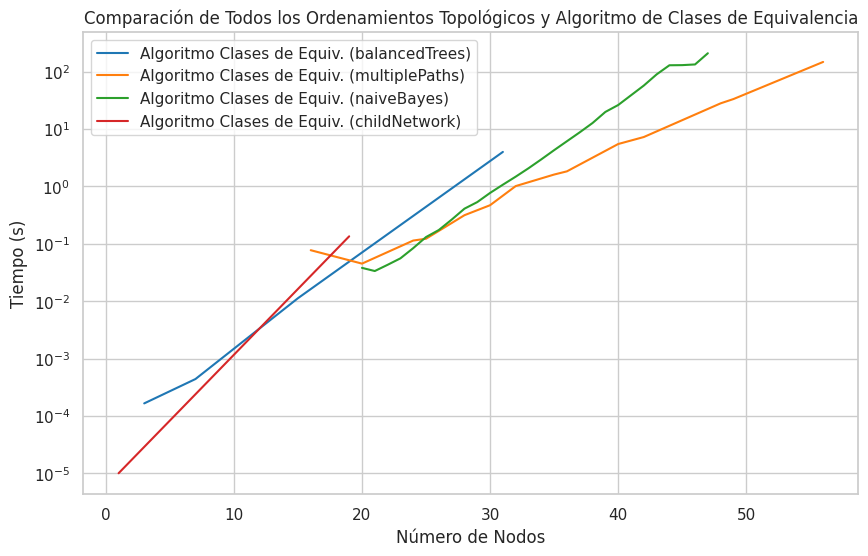

In [14]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

filteredDataFrames = [dfBalancedTrees, dfMultiplePaths, naiveBayesDf, dfChildNetwork]
for df in filteredDataFrames:
    df.dropna(inplace=True,subset=["recursiveAverageTime"])  #Remove the rows where recursiveAverageTime is NaN
    df.sort_values(by="recursiveAverageTime", inplace=True)

palette = sns.color_palette("tab10", n_colors=len(filteredDataFrames))

# Plot each dataframe separately
for i, df in enumerate(filteredDataFrames):
    sns.lineplot(data=df, x="Nodes number", y="recursiveAverageTime", label=f"Algoritmo Clases de Equiv. ({df.name})", color=palette[i], errorbar=None)
    plt.yscale("log")



# Labels and title
plt.xlabel("Número de Nodos")
plt.ylabel("Tiempo (s)")
plt.title("Comparación de Todos los Ordenamientos Topológicos y Algoritmo de Clases de Equivalencia")
 

# Show the plot
plt.legend()
plt.savefig(plotsResultsFolder + 'equivalentClasses_time.png')



### Other plotting

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plotColumns(column1, column2, df, logScale = False):
    sns.set_theme(style='whitegrid')

    plt.figure(figsize=(10, 6))  # Set the figure size
    ax = sns.lineplot(x=column1, y=column2, data=df)

    if logScale:
        ax.set(xscale="log")
        # Define evenly spaced ticks for the x-axis
        min_tick = np.floor(np.log10(naiveBayesDf['allTopoSortsNumber'].min()))
        max_tick = np.ceil(np.log10(naiveBayesDf['allTopoSortsNumber'].max()))
        ticks = np.logspace(min_tick, max_tick, num=5)
        ax.set_xticks(ticks)

    ax.set_xlabel(column1)
    ax.set_ylabel(column2)
    ax.set_title(f'{column1} vs {column2}')

    plt.savefig(f'{plotsResultsFolder}{df.name}-{column1} vs {column2}.png')
    plt.close()
    
    #plt.show()

def plotGraphFamiliy(graphFamiliyData):
    plotColumns('allTopoSortsNumber', 'recursiveAverageTime', graphFamiliyData, True)
    plotColumns('averageEquivClasses', 'recursiveAverageTime', graphFamiliyData)
    plotColumns('averageEquivClasses', 'allTopoSortsNumber', graphFamiliyData)

In [10]:
plotGraphFamiliy(naiveBayesDf)
plotGraphFamiliy(dfMultiplePaths)
plotGraphFamiliy(dfBalancedTrees)

### Optimization experiment

In [11]:
from asvFormula.digraph import *
from asvFormula.classesSizes import equivalanceClassesSizesWithHashes


graphExample = multiplePaths(6,5)

for node in graphExample.nodes:
    classes = equivalanceClassesSizesWithHashes(graphExample, node)
    print(node)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
